#### 라이브러리 불러오기

In [465]:
import os
import platform

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

#### 설정

##### 차트 한글설정

In [466]:
import matplotlib.font_manager as fm
import platform

os_name = platform.system()

# font_path는 사용할 폰트에 따라 변경하면 됨
font_path = 'c:/Windows/Fonts/malgun.ttf' if os_name=='Windows' \
    else '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_family = fm.FontProperties(fname=font_path).get_name()

# font 설정
plt.rcParams['font.family'] = font_family

In [467]:
# 폰트캐시까지 삭제 후 한글폰트가 사용될 수 있도록 캐시 삭제
# --> 이렇게 해야 비로소 한글이 표현되는 경우가 많음
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [font_family]

fe = fm.FontEntry(
    fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic'
)
fm.fontManager.ttflist.insert(0, fe)
# plt.rcParams.update({
#     'font.size': 15, 'font.family': 'NanumGothic'
# })

#### 모델 평가함수 생성

In [468]:
def user_mape(test_y, pred_y):
    # 예측대상(test_y)값이 0인 경우를 대비해, 
    # 0이 아닌 아주 작은수를 더해 MAPE값을 구함
    epsilon = 1e-10
    
    abs_err = np.abs(test_y - pred_y)
    test_y = test_y + epsilon

    p_err = np.where(abs_err==0, 0, abs_err / test_y * 100)
    # 음수 값이면 양수로 변경
    p_err = np.where(p_err<0, -p_err, p_err)
    # 100보다 큰 값은 100으로 제한
    p_err = np.minimum(p_err, 100)
    # MAPE의 평균 반환
    return np.mean(p_err)

def evaluation_func(test_y, pred_y, verbose=1):
    # 모든값을 소숫점 5자리에서 반올림
    _test_y = np.round(test_y, decimals=5)
    _pred_y = np.round(pred_y, decimals=5)
    
    mse = mean_squared_error(_test_y, _pred_y)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(_test_y, _pred_y)
    r2score = r2_score(_test_y, _pred_y)
    mape = mean_absolute_percentage_error(_test_y, _pred_y)
    mape2 = user_mape(_test_y, _pred_y)
    
    if verbose != 0:
        print(
            f'R2_SCORE: {r2score:.6f}, MAPE2: {mape2:.6f}, '
            f'MSE: {mse:.6f}, RMSE: {rmse:.6f}, '
            f'MAPE: {mape:.6f}, MAE: {mae:.6f}'
        )
        
    return mse, rmse, mae, mape, mape2

#### 데이터 불러오기

In [469]:
DATA_PATH = os.path.join(os.getcwd(), 'data', '31-wind-power')
POWER_PATH = os.path.join(DATA_PATH, 'train_energy.csv') 
WEATHER_PATH = os.path.join(DATA_PATH, 'train_weather.csv')
TEST_PATH = os.path.join(DATA_PATH, 'test.csv')

p_df = pd.read_csv(POWER_PATH, encoding='cp949')
w_df = pd.read_csv(WEATHER_PATH)
test_df = pd.read_csv(TEST_PATH)

##### 데이터 확인

In [470]:
# 시계열 데이터를 이용하기 때문에 일자 데이터의 범위와 갯 수 확인
print(
    f'  power: {p_df.일자.min()} ~ {p_df.일자.max()}, cnt: {p_df.shape[0]:>4}\n'
    f'weather: {w_df.tm.min()} ~ {w_df.tm.max()}, {w_df.shape[0]:>9}\n'
    f'   test: {test_df.tm.min()} ~ {test_df.tm.max()}, {test_df.shape[0]:>9}'
)

# 시험데이터(test_df)가 훈련데이터(p/w_df)에 포함됨(과적합발생)
# 훈련데이터(p_df, w_df)간 일자 범위는 같지만 갯 수가 다름(작은쪽으로 수렴)

  power: 2019-01-01 ~ 2021-09-24, cnt:  989
weather: 2019-01-01 ~ 2021-09-24,       998
   test: 2021-06-17 ~ 2021-09-24,       100


#### 데이터 전처리

##### 훈련용 데이터 결합

In [471]:
# 일자 데이터 타입 변경: object -> datetime
p_df.일자 = pd.to_datetime(p_df.일자)
w_df.tm = pd.to_datetime(w_df.tm)

# 일자 데이터를 인덱스로 설정
p_df = p_df.set_index('일자')
w_df = w_df.set_index('tm')

# 인덱스를 이용해 데이터 합치기
train_df = pd.merge(p_df, w_df, left_index=True, right_index=True, how='inner')

##### 시험용 데이터 인덱스 변경

In [472]:
test_df.tm = pd.to_datetime(test_df.tm)
test_df = test_df.set_index('tm')

test_df.index.name = 'index'

# 시험용 데이터 병합시 추가된 것으로 추정되는 '일자_tm', '일자' 컬럼 제거
test_df.drop(columns=['일자_tm', '일자'], axis=1, inplace=True)

##### 컬럼 고유값이 1개인 컬럼 제거

In [473]:
# 고유값이 1개인 컬럼은 모델훈련에 아무 영향을 주지 않기 때문에 제거
# 이때, 훈련데이터에 고유값이 1개지만 시험데이터에 고유값이 여러개인 컬럼 또한 삭제
#  => 훈련시 해당 컬럼이 아무 영향을 주지 못했기 때문에 시험에서도 필요 없음

# 컬럼의 고유값 갯 수 확인
train_n_unique = train_df.nunique()
test_n_unique = test_df.nunique()   # 이건 그냥 확인차
print(
    f'TRAIN: {train_n_unique[train_n_unique==1].index}\n'
    f' TEST: {test_n_unique[test_n_unique==1].index}'
)

# 제거
drop_cols_unique = train_df.columns[train_n_unique==1]
train_df.drop(columns=drop_cols_unique, axis=1, inplace=True)
test_df.drop(columns=drop_cols_unique, axis=1, inplace=True)

TRAIN: Index(['발전기명(WTG)', '발전기(Serial)', '발전용량(kW)', '위치', 'stnId', 'stnNm'], dtype='object')
 TEST: Index(['stnId', 'stnNm', '발전기명(WTG)', '발전기(Serial)', '발전용량(kW)', '위치'], dtype='object')


##### 훈련데이터와 시험데이터 컬럼 일치시키기

In [474]:
# 양쪽에 모두 있는 컬럼만 훈련과 시험에 필요하기 때문에,
# 여기서는 컬럼수가 더 적은 시험데이터에 훈련데이터 컬럼을 맞춤
print(f'BEFORE TRAIN: {train_df.shape}, TEST: {test_df.shape}')
train_df = train_df[test_df.columns]
print(f'AFTER  TRAIN: {train_df.shape}, TEST: {test_df.shape}')

BEFORE TRAIN: (989, 68), TEST: (100, 49)
AFTER  TRAIN: (989, 49), TEST: (100, 49)


##### 결측치 처리

In [475]:
train_df.isna().sum().sort_values(ascending=False)

avgLmac           25
sumSmlEv          17
sumLrgEv          17
maxWd             12
avgCm30Te         10
avgCm20Te         10
avgCm10Te         10
avgCm5Te          10
avgTa              5
avgRhm             5
sumGsr             5
hr1MaxIcsr         5
hr1MaxIcsrHrmt     5
avgPa              5
avgPv              5
avgPs              5
avgTd              5
avgTca             3
sumSsHr            2
ssDur              1
maxTa              1
maxTaHrmt          0
minTaHrmt          0
발전량(kWh)           0
최저풍속(m-s)          0
minRhmHrmt         0
maxInsWsWd         0
평균풍속(m-s)          0
최대풍속(m-s)          0
최소발전량(kW)          0
평균발전량(kW)          0
최대발전량(kW)          0
이용률(백분율)           0
maxInsWs           0
avgTs              0
maxInsWsHrmt       0
minTg              0
minRhm             0
maxWs              0
maxWsWd            0
maxWsHrmt          0
avgWs              0
minTa              0
minPsHrmt          0
minPs              0
maxPsHrmt          0
maxPs              0
hr24SumRws   

In [476]:
# 인덱스가 시계열 컬럼일 경우, 시계열성을 반영해 중간값 지정
train_df = train_df.interpolate()

In [477]:
train_df.isna().sum().sort_values(ascending=False)

avgTa             0
ssDur             0
hr1MaxIcsrHrmt    0
hr1MaxIcsr        0
sumGsr            0
avgTca            0
avgLmac           0
avgTs             0
minTg             0
avgCm5Te          0
avgCm10Te         0
avgCm20Te         0
avgCm30Te         0
sumLrgEv          0
sumSmlEv          0
발전량(kWh)          0
최저풍속(m-s)         0
평균풍속(m-s)         0
최대풍속(m-s)         0
최소발전량(kW)         0
평균발전량(kW)         0
최대발전량(kW)         0
이용률(백분율)          0
sumSsHr           0
avgPs             0
minTa             0
minPsHrmt         0
minTaHrmt         0
maxTa             0
maxTaHrmt         0
maxInsWs          0
maxInsWsWd        0
maxInsWsHrmt      0
maxWs             0
maxWsWd           0
maxWsHrmt         0
avgWs             0
hr24SumRws        0
maxWd             0
avgTd             0
minRhm            0
minRhmHrmt        0
avgRhm            0
avgPv             0
avgPa             0
maxPs             0
maxPsHrmt         0
minPs             0
가동율(백분율)          0
dtype: int64

##### 속성과 예측값(target) 분류

In [478]:
target_col = '발전량(kWh)'

train_x = train_df.drop(target_col, axis=1)
train_y = train_df[target_col]
test_x = test_df.drop(target_col, axis=1)
test_y = test_df[target_col]

#### 1차 모델링
* 컬럼 조정하고, 결측치만 처리한 데이터
* 여기에는 아직 훈련데이터에 시험데이터가 포함되어 있음

##### 훈련데이터에 시험데이터 포함

* [ML] DecisionTreeRegressor

In [479]:
# 특별한 처리없이 기본값으로 처리
model_dtr = DecisionTreeRegressor().fit(train_x, train_y)
pred_dtr = model_dtr.predict(test_x)
_ = evaluation_func(test_y, pred_dtr)

# ML의 경우 훈련데이터에 포함된 시험데이터에 대한 오차가 0(100% 맞춤)이다.(과적합)

R2_SCORE: 1.000000, MAPE2: 0.000000, MSE: 0.000000, RMSE: 0.000000, MAPE: 0.000000, MAE: 0.000000


* [DL] MLP(Multi-Layer Perceptron)

In [480]:
model_mlp = tf.keras.Sequential([
    Dense(128, activation='relu', input_shape=(train_x.shape[1:])),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    # 회귀모델의 출력층은 활성화함수를 사용하지 않음
    Dense(1)
])

model_mlp.compile(
    optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mape']
)

model_mlp.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 128)               6272      
                                                                 
 dense_41 (Dense)            (None, 64)                8256      
                                                                 
 dense_42 (Dense)            (None, 32)                2080      
                                                                 
 dense_43 (Dense)            (None, 1)                 33        
                                                                 
Total params: 16,641
Trainable params: 16,641
Non-trainable params: 0
_________________________________________________________________


In [481]:
model_mlp.fit(
    train_x, train_y,
    epochs=150, verbose=0, validation_split=0.2
)

In [482]:
model_mlp.evaluate(test_x, test_y, verbose=0)

[271880.3125, 423.6714782714844, 4005607168.0]

In [483]:
pred_mlp = model_mlp.predict(test_x, verbose=0).reshape(100)
_ = evaluation_func(test_y, pred_mlp)

R2_SCORE: 0.995628, MAPE2: 21.654659, MSE: 271880.243893, RMSE: 521.421369, MAPE: 18039650855598160.000000, MAE: 423.671478


##### 훈련데이터에 시험데이터 제거 후 시험

In [484]:
# `데이터 확인`에서 시험데이터의 시작 일자가 `2021-06-17`이니,
# 훈련데이터에서 이후 데이터 삭제
cutoff_date = pd.to_datetime('2021-06-17')
cutoff_df = train_df.loc[train_df.index < cutoff_date]

In [485]:
cutoff_x = cutoff_df.drop(target_col, axis=1)
cutoff_y = cutoff_df[target_col]

* [ML] DecisionTreeRegressor

In [486]:
# 특별한 처리없이 기본값으로 처리
model_cdtr = DecisionTreeRegressor().fit(cutoff_x, cutoff_y)
pred_cdtr = model_cdtr.predict(test_x)
_ = evaluation_func(test_y, pred_cdtr)

# ML의 경우 훈련데이터에 시험데이터가 빠져도 성능이 과적합에 가깝다
# 정말 이렇게 잘 맞춘다고??? 

R2_SCORE: 0.999846, MAPE2: 3.109547, MSE: 9597.999152, RMSE: 97.969379, MAPE: 703732477772913.625000, MAE: 54.874860


* [ML] Lasso

In [487]:
model_ls = Lasso().fit(cutoff_x, cutoff_y)
pred_ls = model_ls.predict(test_x)
_ = evaluation_func(test_y, pred_ls)

R2_SCORE: 0.999999, MAPE2: 2.411573, MSE: 86.366001, RMSE: 9.293331, MAPE: 534965936416720.000000, MAE: 7.161157


* 데이터를 임의로 만든거 같음;;; 너무 정확해;;;;;;;

#### 이미지

##### Lasso 예측치와 실제값

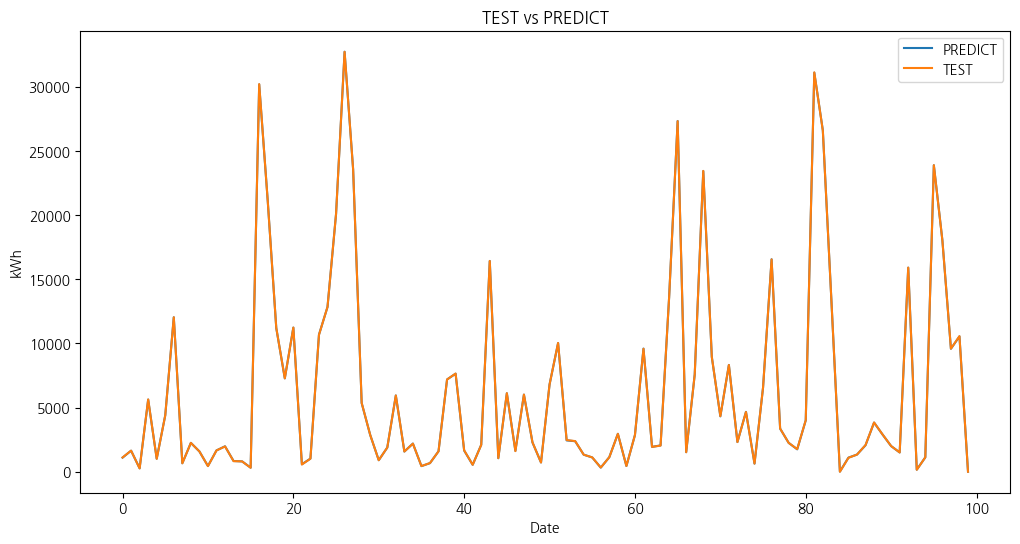

In [488]:
plt.figure(figsize=(12,6))

plt.plot(pred_ls, label='PREDICT')
plt.plot(test_y.values, label='TEST')
plt.title('TEST vs PREDICT')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.show()

# 100% 일치;;;;;

##### DTR 모델에 영향을 준 속성들

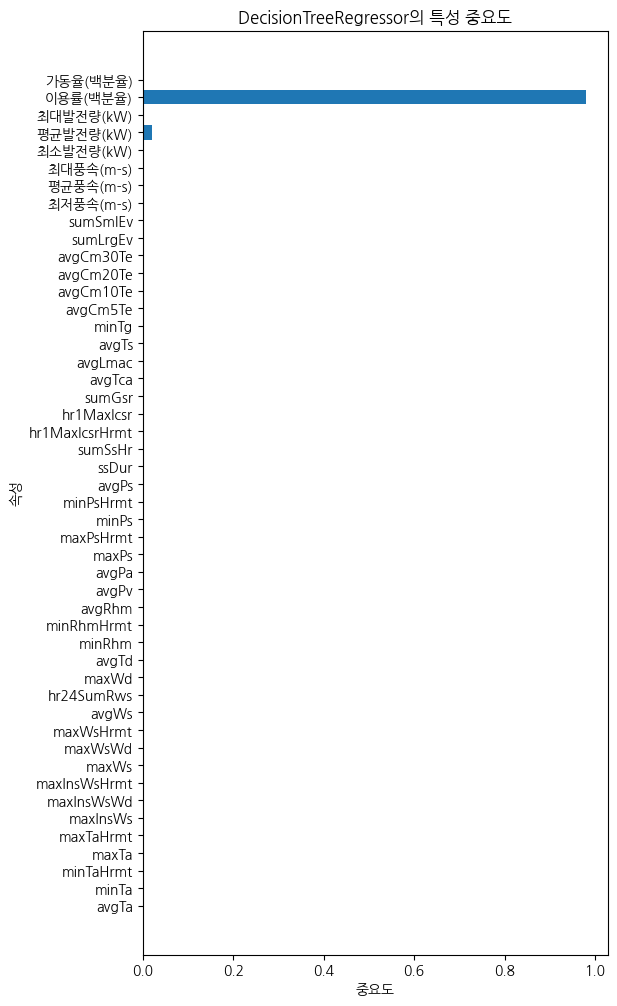

In [489]:
f_importances = model_dtr.feature_importances_

plt.figure(figsize=(6,12))
plt.barh(range(len(f_importances)), f_importances)
plt.yticks(range(len(f_importances)), train_x.columns)
plt.xlabel('중요도')
plt.ylabel('속성')
plt.title('DecisionTreeRegressor의 특성 중요도')
plt.show()

#### 컬럼값 확인

##### 목표값과 이용률 관계 확인

In [490]:
temp_df = train_df.copy()

In [491]:
temp_df['ppu'] = temp_df[target_col] / temp_df['이용률(백분율)']
# ppu컬럼값을 확인해보면 551.9xxx ~ 552.1xxxx(대략평균 552)

##### w_df와 p_df컬럼의 중복컬럼 체크

In [492]:
w_df.columns

Index(['stnId', 'stnNm', 'avgTa', 'minTa', 'minTaHrmt', 'maxTa', 'maxTaHrmt',
       'mi10MaxRn', 'mi10MaxRnHrmt', 'hr1MaxRn', 'hr1MaxRnHrmt', 'sumRnDur',
       'sumRn', 'maxInsWs', 'maxInsWsWd', 'maxInsWsHrmt', 'maxWs', 'maxWsWd',
       'maxWsHrmt', 'avgWs', 'hr24SumRws', 'maxWd', 'avgTd', 'minRhm',
       'minRhmHrmt', 'avgRhm', 'avgPv', 'avgPa', 'maxPs', 'maxPsHrmt', 'minPs',
       'minPsHrmt', 'avgPs', 'ssDur', 'sumSsHr', 'hr1MaxIcsrHrmt',
       'hr1MaxIcsr', 'sumGsr', 'ddMefs', 'ddMefsHrmt', 'ddMes', 'ddMesHrmt',
       'sumDpthFhsc', 'avgTca', 'avgLmac', 'avgTs', 'minTg', 'avgCm5Te',
       'avgCm10Te', 'avgCm20Te', 'avgCm30Te', 'avgM05Te', 'avgM10Te',
       'avgM15Te', 'avgM30Te', 'avgM50Te', 'sumLrgEv', 'sumSmlEv', 'n99Rn',
       'iscs', 'sumFogDur'],
      dtype='object')

##### w_df 컬럼
* stnId: 기상 관측소 ID
* stnNm: 기상 관측소 이름
* avgTa: 평균 기온 (℃)
* minTa: 최저 기온 (℃)
* minTaHrmt: 최저 기온 발생 시각 (시간)
* maxTa: 최고 기온 (℃)
* maxTaHrmt: 최고 기온 발생 시각 (시간)
* mi10MaxRn: 10분 간 최대 강수량 (mm)
* mi10MaxRnHrmt: 10분 간 최대 강수량 발생 시각 (시간)
* hr1MaxRn: 1시간 간 최대 강수량 (mm)
* hr1MaxRnHrmt: 1시간 간 최대 강수량 발생 시각 (시간)
* sumRnDur: 강수 지속 시간 합계 (분)
* sumRn: 총 강수량 (mm)
* maxInsWs: 최대 순간 풍속 (m/s)
* maxInsWsWd: 최대 순간 풍향 (16방위)
* maxInsWsHrmt: 최대 순간 풍속 발생 시각 (시간)
* maxWs: 최대 풍속 (m/s)
* maxWsWd: 최대 풍향 (16방위)
* maxWsHrmt: 최대 풍속 발생 시각 (시간)
* avgWs: 평균 풍속 (m/s)
* hr24SumRws: 24시간간 비바람 시간 합 (시간)
* maxWd: 최대 풍향 (16방위)
* avgTd: 평균 이슬점 온도 (℃)
* minRhm: 최소 상대습도 (%)
* minRhmHrmt: 최소 상대습도 발생 시각 (시간)
* avgRhm: 평균 상대습도 (%)
* avgPv: 평균 증기압 (hPa)
* avgPa: 평균 대기압 (hPa)
* maxPs: 최고 해면 기압 (hPa)
* maxPsHrmt: 최고 해면 기압 발생 시각 (시간)
* minPs: 최저 해면 기압 (hPa)
* minPsHrmt: 최저 해면 기압 발생 시각 (시간)
* avgPs: 평균 해면 기압 (hPa)
* ssDur: 일조 지속 시간 (분)
* sumSsHr: 합계 일조 시간 (시간)
* hr1MaxIcsrHrmt: 1시간 최대 일사량 발생 시각 (시간)
* hr1MaxIcsr: 1시간 최대 일사량 (MJ/m²)
* sumGsr: 합계 일사량 (MJ/m²)
* ddMefs: 안개 계속 시간 (시간)
* ddMefsHrmt: 안개 계속 시간 발생 시각 (시간)
* ddMes: 안개 지속 시간 (시간)
* ddMesHrmt: 안개 지속 시간 발생 시각 (시간)
* sumDpthFhsc: 적설 누적 깊이 (cm)
* avgTca: 평균 전운량 (1/10)
* avgLmac: 평균 중하층운량 (1/10)
* avgTs: 평균 지면 온도 (℃)
* minTg: 최저 지면 온도 (℃)
* avgCm5Te: 5cm 지중온도 (℃)
* avgCm10Te: 10cm 지중온도 (℃)
* avgCm20Te: 20cm 지중온도 (℃)
* avgCm30Te: 30cm 지중온도 (℃)
* avgM05Te: 0.5m 수중온도 (℃)
* avgM10Te: 1.0m 수중온도 (℃)
* avgM15Te: 1.5m 수중온도 (℃)
* avgM30Te: 3.0m 수중온도 (℃)
* avgM50Te: 5.0m 수중온도 (℃)
* sumLrgEv: 대형증발량 (mm)
* sumSmlEv: 소형증발량 (mm)
* n99Rn: 강수 형태 코드
* iscs: 지면 결빙 코드
* sumFogDur: 안개 지속 시간 합계 (분)

In [493]:
train_df[['maxWs', '최대풍속(m-s)', 'avgWs', '평균풍속(m-s)']]
# 같은날 서로 다른 데이터셋의 최대풍속과 평균풍속이 너무 차이가 남
# 일단 이것도 데이터로서 가치가 있다(?)고 생각하고 '이용률'만 제거하고 다시 실행

,maxWs,최대풍속(m-s),avgWs,평균풍속(m-s)
2019-01-01,6.3,16.818,2.8,8.438
2019-01-02,5.6,13.564,2.0,5.702
2019-01-03,5.5,11.386,1.9,4.884
2019-01-04,2.9,8.855,0.9,2.473
2019-01-05,5.9,14.735,2.3,6.358
...,...,...,...,...
2021-09-20,5.2,18.885,2.5,8.043
2021-09-21,4.9,17.879,2.4,7.116
2021-09-22,3.8,11.873,1.6,5.238
2021-09-23,5.2,10.665,1.2,5.762


#### `이용률(백분율)` 컬럼 제거

In [494]:
cutoff_x_xu = cutoff_x.copy()
cutoff_x_xu.drop('이용률(백분율)', axis=1, inplace=True)

test_x_xu = test_x.copy()
test_x_xu.drop('이용률(백분율)', axis=1, inplace=True)

##### DTR 모델링

In [495]:
# 특별한 처리없이 기본값으로 처리
model_dtr_xu = DecisionTreeRegressor().fit(cutoff_x_xu, cutoff_y)
pred_dtr_xu = model_dtr_xu.predict(test_x_xu)
_ = evaluation_func(test_y, pred_dtr_xu)

R2_SCORE: 0.999379, MAPE2: 3.169807, MSE: 38623.592394, RMSE: 196.528859, MAPE: 0.031698, MAE: 92.210750


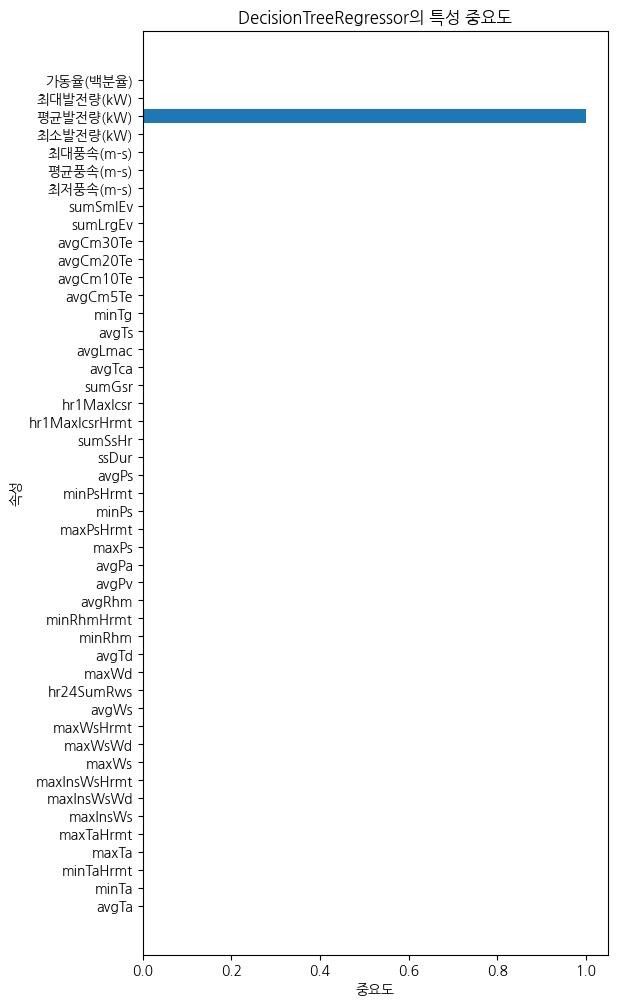

In [496]:
f_importances_xu = model_dtr_xu.feature_importances_

plt.figure(figsize=(6,12))
plt.barh(range(len(f_importances_xu)), f_importances_xu)
plt.yticks(range(len(f_importances_xu)), cutoff_x_xu.columns)
plt.xlabel('중요도')
plt.ylabel('속성')
plt.title('DecisionTreeRegressor의 특성 중요도')
plt.show()

#### `평균발전량` 컬럼 제거

In [497]:
cutoff_x_xu.drop('평균발전량(kW)', axis=1, inplace=True)
test_x_xu.drop('평균발전량(kW)', axis=1, inplace=True)

In [498]:
# 특별한 처리없이 기본값으로 처리
model_dtr_xu = DecisionTreeRegressor().fit(cutoff_x_xu, cutoff_y)
pred_dtr_xu = model_dtr_xu.predict(test_x_xu)
_ = evaluation_func(test_y, pred_dtr_xu)

R2_SCORE: 0.959391, MAPE2: 23.995212, MSE: 2525455.766420, RMSE: 1589.168262, MAPE: 703732477772913.875000, MAE: 981.158390


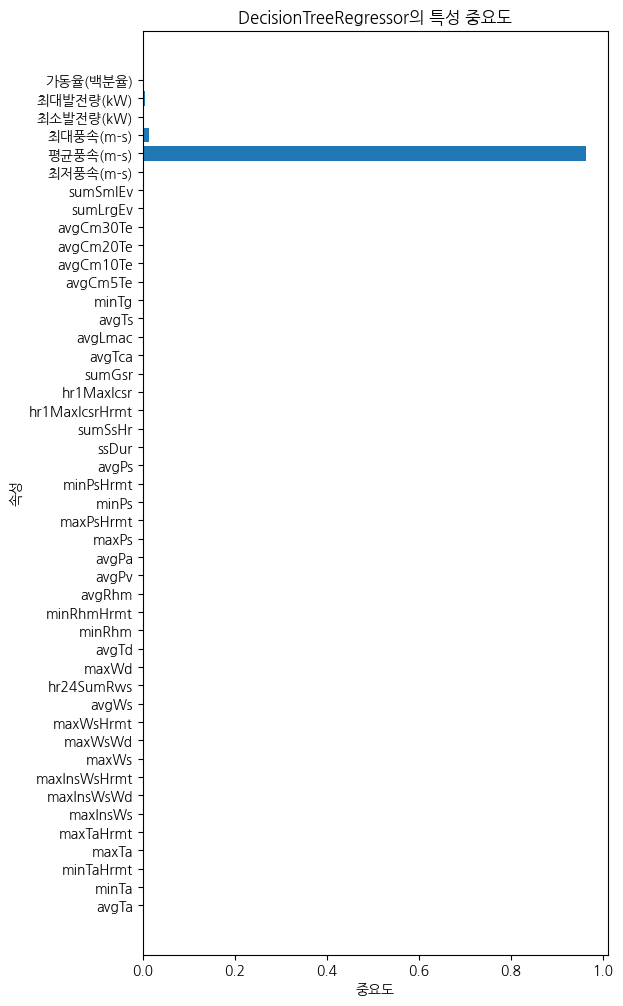

In [499]:
f_importances_xu = model_dtr_xu.feature_importances_

plt.figure(figsize=(6,12))
plt.barh(range(len(f_importances_xu)), f_importances_xu)
plt.yticks(range(len(f_importances_xu)), cutoff_x_xu.columns)
plt.xlabel('중요도')
plt.ylabel('속성')
plt.title('DecisionTreeRegressor의 특성 중요도')
plt.show()

#### p_df 컬럼 모두 삭제

In [500]:
drop_p_colos = ['가동율(백분율)', '최저풍속(m-s)', '평균풍속(m-s)', '최대풍속(m-s)', '최소발전량(kW)', '최대발전량(kW)']

cutoff_x_xu.drop(columns=drop_p_colos, axis=1, inplace=True)
test_x_xu.drop(columns=drop_p_colos, axis=1, inplace=True)

In [501]:
# 특별한 처리없이 기본값으로 처리
model_dtr_xu = DecisionTreeRegressor().fit(cutoff_x_xu, cutoff_y)
pred_dtr_xu = model_dtr_xu.predict(test_x_xu)
_ = evaluation_func(test_y, pred_dtr_xu)

R2_SCORE: 0.789607, MAPE2: 50.189436, MSE: 13084115.035074, RMSE: 3617.197124, MAPE: 109929173952419376.000000, MAE: 2377.205880


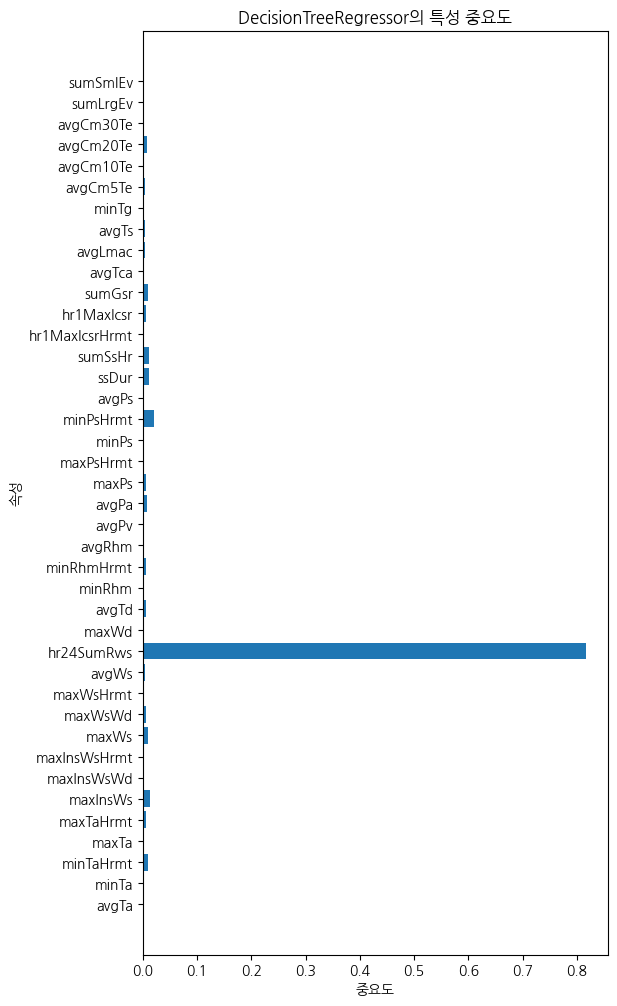

In [502]:
f_importances_xu = model_dtr_xu.feature_importances_

plt.figure(figsize=(6,12))
plt.barh(range(len(f_importances_xu)), f_importances_xu)
plt.yticks(range(len(f_importances_xu)), cutoff_x_xu.columns)
plt.xlabel('중요도')
plt.ylabel('속성')
plt.title('DecisionTreeRegressor의 특성 중요도')
plt.show()

In [506]:
for t, p in zip(test_y, pred_dtr_xu):
    print(
        f'TEST: {t:>10.4f}, PREDICT: {p:>10.4f} '
        f'--> ABS: {np.abs(t-p):>10.4f}'
    )

TEST:  1110.3520, PREDICT:  2916.0160 --> ABS:  1805.6640
TEST:  1642.5780, PREDICT:  8756.3480 --> ABS:  7113.7700
TEST:   256.8360, PREDICT:   234.1310 --> ABS:    22.7050
TEST:  5632.8130, PREDICT: 10169.9220 --> ABS:  4537.1090
TEST:  1004.8830, PREDICT:  2343.7500 --> ABS:  1338.8670
TEST:  4392.5780, PREDICT:  5261.2300 --> ABS:   868.6520
TEST: 12038.0860, PREDICT:  8991.2110 --> ABS:  3046.8750
TEST:   657.2270, PREDICT:   898.4380 --> ABS:   241.2110
TEST:  2247.0700, PREDICT:   448.4860 --> ABS:  1798.5840
TEST:  1581.0550, PREDICT:   448.4860 --> ABS:  1132.5690
TEST:   438.4770, PREDICT:  2429.9320 --> ABS:  1991.4550
TEST:  1658.2030, PREDICT:  2621.0940 --> ABS:   962.8910
TEST:  1970.7030, PREDICT:   958.0080 --> ABS:  1012.6950
TEST:   823.2420, PREDICT:   993.1640 --> ABS:   169.9220
TEST:   805.6640, PREDICT:   993.1640 --> ABS:   187.5000
TEST:   307.6170, PREDICT:   649.9020 --> ABS:   342.2850
TEST: 30206.0550, PREDICT: 35972.6560 --> ABS:  5766.6010
TEST: 21102.53

: 